<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Map_Coloring_May%26June_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://dmcommunity.org/wp-content/uploads/2019/05/mapcoloring.png)

This challenge deals with map coloring.  You need to use no more than 4 colors (blue, red, green, or yellow) to color six European countries: Belgium, Denmark, France, Germany, Luxembourg, and the Netherlands in such a way that no neighboring countries use the same color.


In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

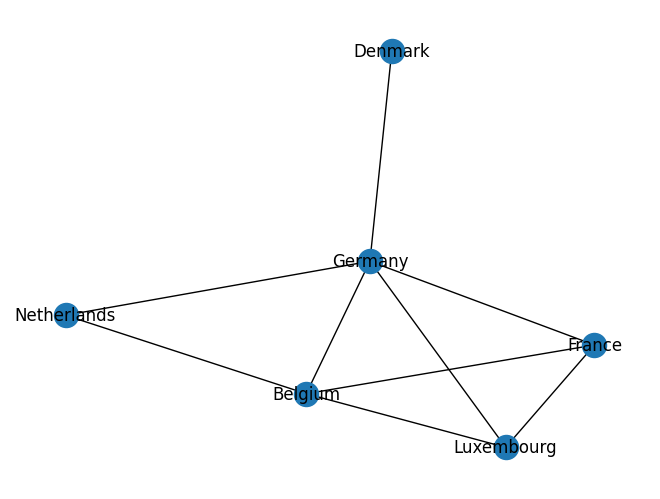

In [ ]:
neighboring_countries = [('France', 'Belgium'), ('France', 'Luxembourg'), ('France', 'Germany'),
           ('Luxembourg', 'Belgium'), ('Luxembourg', 'Germany'),
           ('Belgium','Netherlands'), ('Belgium','Germany'),
           ('Netherlands','Germany'),
           ('Germany','Denmark')]

G = nx.Graph()

for i,j in neighboring_countries:
  G.add_edge(i,j)
my_pos = nx.spring_layout(G, seed = 10)
nx.draw(G, pos = my_pos, with_labels = True)

In [ ]:
model = ConcreteModel()

model.I = ['France', 'Belgium', 'Luxembourg', 'Germany', 'Netherlands', 'Denmark']
model.J = ['Blue', 'Red', 'Green', 'Yellow']
# Neighboring countries
model.K = neighboring_countries

model.X = Var(model.I, model.J, within = Binary)

def con0_rule(model,i):
  return sum(model.X[i,j] for j in model.J) == 1
model.con0 = Constraint(model.I, rule = con0_rule)

# No two neighboring countries should have the same color
def con1_rule(model, i, k, j):
  return model.X[i,j] <= 1 - model.X[k,j]
model.con1 = Constraint(model.K, model.J, rule = con1_rule)

In [ ]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.01


In [ ]:
x = model.X.extract_values()
sol = {}
for i,j in x.keys():
  if x[i,j] > 0:
    sol[i] = j

for i in range(len(sol)):
  print("{0} {1}".format(list(sol.keys())[i], list(sol.values())[i]))

France Blue
Belgium Yellow
Luxembourg Green
Germany Red
Netherlands Blue
Denmark Blue


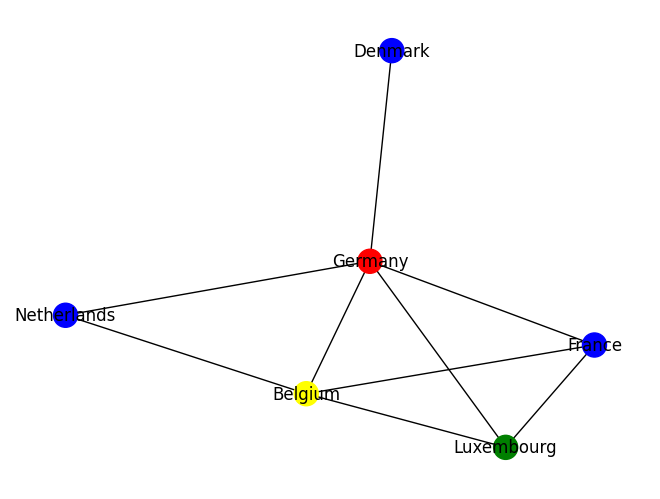

In [ ]:
G = nx.Graph()
# Add nodes and edges
for i,j in model.K:
  G.add_edge(i,j)
my_pos = nx.spring_layout(G, seed = 10)
nx.draw(G, pos = my_pos, node_color = sol.values(), with_labels = True)

# Map Coloring with Violations

![](https://dmcommunity.org/wp-content/uploads/2019/05/mapcoloring.png)

You have only 3 colors (blue, red, green). Some neighboring countries may have the same colors but there is a relative cost for such violations:

1. France – Luxembourg: \$257
2. Luxembourg – Germany: \$904
3. Luxembourg – Belgium: \$568

In [ ]:
model = ConcreteModel()

model.I = ['France', 'Belgium', 'Luxembourg', 'Germany', 'Netherlands', 'Denmark']
model.J = ['Blue', 'Red', 'Green']

# Countries with violations
model.V = [('France', 'Belgium'),
           ('Luxembourg', 'Belgium'), ('Luxembourg', 'Germany')]

model.X = Var(model.I, model.J, within = Binary)

def con0_rule(model,i):
  return sum(model.X[i,j] for j in model.J) == 1
model.con0 = Constraint(model.I, rule = con0_rule)

def obj_rule(model):
  return 257*sum(model.X[i,j]*model.X[k,j] for (i,k) in model.V if (i,k) == ('France', 'Luxembourg') for j in model.J ) \
        + 904*sum(model.X[i,j]*model.X[k,j] for (i,k) in model.V if (i,k) == ('Luxembourg', 'Germany') for j in model.J ) \
        + 568*sum(model.X[i,j]*model.X[k,j] for (i,k) in model.V if (i,k) == ('Luxembourg', 'Belgium') for j in model.J ) \

model.obj = Objective(rule = obj_rule, sense = minimize)

In [ ]:
# Solve model
opt = SolverFactory('bonmin')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  <undefined>


In [ ]:
x = model.X.extract_values()
sol = {}
for i,j in x.keys():
  if x[i,j] > 0:
    sol[i] = j

for i in range(len(sol)):
  print("{0} {1}".format(list(sol.keys())[i], list(sol.values())[i]))

France Blue
Belgium Red
Luxembourg Green
Germany Red
Netherlands Blue
Denmark Blue


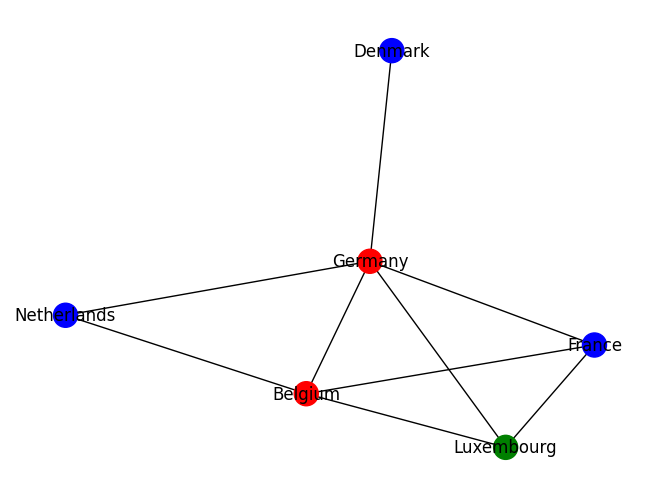

In [ ]:
G = nx.Graph()
# Add nodes and edges
for i,j in neighboring_countries:
  G.add_edge(i,j)
my_pos = nx.spring_layout(G, seed = 10)
nx.draw(G, pos = my_pos, node_color = sol.values(), with_labels = True)